In [1]:
import random
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from concurrent.futures import ThreadPoolExecutor

In [2]:
# --- MonteCarloSimulator Class ---
class MonteCarloSimulator:
    NUMBERS_POOL = range(1, 60)  # Numbers from 1 to 59
    NUMBERS_DRAWN = 6  # Number of main numbers drawn
    BONUS_NUMBER = 1  # Number of bonus balls drawn

    prizes = {
        "Jackpot": 10000000,
        "Match 5 + Bonus": 50000,
        "Match 5": 1000,
        "Match 4": 100,
        "Match 3": 25,
        "Match 2": 0,
        "No Win": 0
    }

    def __init__(self, user_number, simulations):
        self.simulations = simulations
        self.user_number = sorted(user_number)  # Ensure user numbers are sorted
        self.ticket_cost = 2

    @staticmethod
    def draw_lotto():
        main_numbers = sorted(random.sample(MonteCarloSimulator.NUMBERS_POOL, MonteCarloSimulator.NUMBERS_DRAWN))
        remaining_numbers = [n for n in MonteCarloSimulator.NUMBERS_POOL if n not in main_numbers]
        bonus_number = random.choice(remaining_numbers)
        return main_numbers, bonus_number

    def generate_ticket(self):
        return self.user_number

    def determine_prize(self, ticket, draw_results):
        main_numbers, bonus_number = draw_results
        matched_main = len(set(ticket) & set(main_numbers))
        won_bonus = bonus_number in ticket
        if matched_main == 6:
            return "Jackpot"
        elif matched_main == 5 and won_bonus:
            return "Match 5 + Bonus"
        elif matched_main == 5:
            return "Match 5"
        elif matched_main == 4:
            return "Match 4"
        elif matched_main == 3:
            return "Match 3"
        elif matched_main == 2:
            return "Match 2"
        else:
            return "No Win"

    def simulate_single_process(self, num_simulations):
        outcomes = {key: 0 for key in self.prizes.keys()}
        ticket = self.generate_ticket()
        for _ in range(num_simulations):
            draw_results = self.draw_lotto()
            outcome = self.determine_prize(ticket, draw_results)
            outcomes[outcome] += 1
        return outcomes

    @staticmethod
    def merge_results(results_list):
        final_outcomes = {key: 0 for key in MonteCarloSimulator.prizes.keys()}
        for result in results_list:
            for key in result:
                final_outcomes[key] += result[key]
        return final_outcomes

    def monte_carlo_simulation(self):
        num_threads = 4  # Adjust based on Colab resources (e.g., 2 or 4)
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            simulations_per_thread = self.simulations // num_threads
            extra_simulations = self.simulations % num_threads
            simulations_list = [simulations_per_thread + 1 if i < extra_simulations else simulations_per_thread for i in range(num_threads)]
            futures = [executor.submit(self.simulate_single_process, sim) for sim in simulations_list]
            results = [future.result() for future in futures]
        outcomes = self.merge_results(results)
        probabilities = {key: outcomes[key] / self.simulations for key in outcomes}
        expected_return = sum(probabilities[key] * self.prizes[key] for key in self.prizes)
        total_investment = self.simulations * self.ticket_cost
        total_earning = expected_return * self.simulations
        balance = total_earning - total_investment
        return {
            "probabilities": probabilities,
            "expected_return": expected_return,
            "total_investment": total_investment,
            "total_earning": total_earning,
            "balance": balance
        }

In [3]:
# --- HistoricalBasedSimulator Class ---
class HistoricalBasedSimulator:
    NUMBERS_POOL = range(1, 60)
    NUMBERS_DRAWN = 6
    BONUS_NUMBER = 1
    prizes = {
        "Jackpot": 10000000,
        "Match 5 + Bonus": 50000,
        "Match 5": 1000,
        "Match 4": 100,
        "Match 3": 25,
        "Match 2": 0,
        "No Win": 0
    }

    def __init__(self, user_number, simulations, historical_draws):
        self.simulations = simulations
        self.historical_draws = historical_draws
        self.user_number = sorted(user_number)
        self.ticket_cost = 2
        self.number_frequency = self.calculate_number_frequency()

    def get_draw_history(self):
        return self.historical_draws

    def calculate_number_frequency(self):
        all_numbers = self.get_draw_history()
        numbers = []
        for draw in all_numbers:
            numbers.extend(draw)
        return Counter(numbers)

    def weighted_draw(self):
        lotto_numbers = list(range(1, 60))
        total_draws = sum(self.number_frequency.values())
        weights = [(self.number_frequency.get(num, 0) / total_draws) for num in lotto_numbers]
        main_numbers = sorted(random.choices(lotto_numbers, weights=weights, k=6))
        remaining_numbers = [n for n in lotto_numbers if n not in main_numbers]
        bonus_number = random.choice(remaining_numbers)
        return main_numbers, bonus_number

    def generate_ticket(self):
        return self.user_number

    def determine_prize(self, ticket, draw_results):
        main_numbers, bonus_number = draw_results
        matched_main = len(set(ticket) & set(main_numbers))
        won_bonus = bonus_number in ticket
        if matched_main == 6:
            return "Jackpot"
        elif matched_main == 5 and won_bonus:
            return "Match 5 + Bonus"
        elif matched_main == 5:
            return "Match 5"
        elif matched_main == 4:
            return "Match 4"
        elif matched_main == 3:
            return "Match 3"
        elif matched_main == 2:
            return "Match 2"
        else:
            return "No Win"

    def simulate_single_process(self, num_simulations):
        outcomes = {key: 0 for key in self.prizes.keys()}
        ticket = self.generate_ticket()
        for _ in range(num_simulations):
            draw_results = self.weighted_draw()
            outcome = self.determine_prize(ticket, draw_results)
            outcomes[outcome] += 1
        return outcomes

    @staticmethod
    def merge_results(results_list):
        final_outcomes = {key: 0 for key in HistoricalBasedSimulator.prizes.keys()}
        for result in results_list:
            for key in result:
                final_outcomes[key] += result[key]
        return final_outcomes

    def monte_carlo_simulation(self):
        num_threads = 4  # Adjust based on Colab resources (e.g., 2 or 4)
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            simulations_per_thread = self.simulations // num_threads
            extra_simulations = self.simulations % num_threads
            simulations_list = [simulations_per_thread + 1 if i < extra_simulations else simulations_per_thread for i in range(num_threads)]
            futures = [executor.submit(self.simulate_single_process, sim) for sim in simulations_list]
            results = [future.result() for future in futures]
        outcomes = self.merge_results(results)
        probabilities = {key: outcomes[key] / self.simulations for key in outcomes}
        expected_return = sum(probabilities[key] * self.prizes[key] for key in self.prizes)
        total_investment = self.simulations * self.ticket_cost
        total_earning = expected_return * self.simulations
        balance = total_earning - total_investment
        return {
            "probabilities": probabilities,
            "expected_return": expected_return,
            "total_investment": total_investment,
            "total_earning": total_earning,
            "balance": balance
        }


In [4]:
# --- Helper Functions ---
def calculate_simulations(years, weekly_draws):
    return int(years) * int(weekly_draws) * 52

def get_dummy_historical_draws(num_draws=1000):
    draws = [sorted(random.sample(range(1, 60), 6)) for _ in range(num_draws)]
    return draws

Using dummy values: numbers=[1, 2, 3, 4, 5, 6], years=1, weekly_draws=2, algorithm=1
Running 104 simulations...

Probabilities of winning each prize:
                 Probability
Jackpot             0.000000
Match 5 + Bonus     0.000000
Match 5             0.000000
Match 4             0.000000
Match 3             0.961538
Match 2             5.769231
No Win             93.269231

Financial Summary:
Expected return per ticket: £0.24
Total investment: £208.00
Total expected earnings: £25.00
Net balance: £-183.00


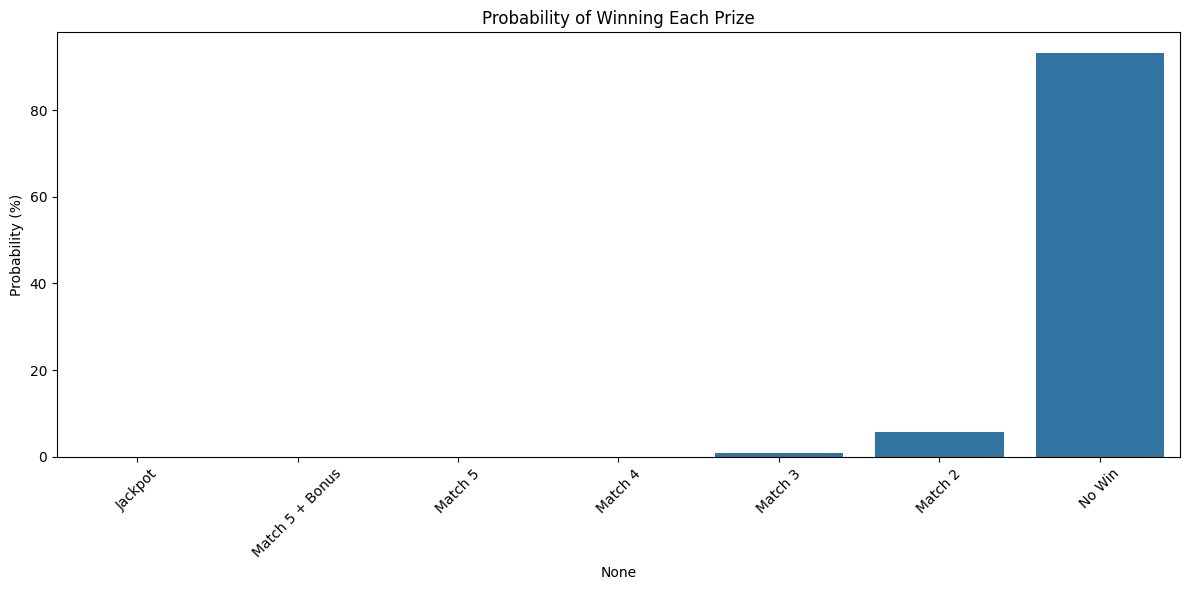

In [5]:
# --- Main Function ---
def main():
    # Dummy values for demonstration
    user_numbers = [1, 2, 3, 4, 5, 6]
    years = 1
    weekly_draws = 2
    algo_choice = '1'  # '1' for Monte Carlo, '2' for Historical
    print(f"Using dummy values: numbers={user_numbers}, years={years}, weekly_draws={weekly_draws}, algorithm={algo_choice}")
    num_simulations = calculate_simulations(years, weekly_draws)
    print(f"Running {num_simulations} simulations...")
    if algo_choice == '1':
        simulator = MonteCarloSimulator(user_numbers, num_simulations)
        results = simulator.monte_carlo_simulation()
    elif algo_choice == '2':
        historical_draws = get_dummy_historical_draws()
        simulator = HistoricalBasedSimulator(user_numbers, num_simulations, historical_draws)
        results = simulator.monte_carlo_simulation()
    else:
        print("Invalid algorithm choice.")
        sys.exit(1)
    # Display results
    probabilities_df = pd.DataFrame.from_dict(results['probabilities'], orient='index', columns=['Probability'])
    probabilities_df['Probability'] = probabilities_df['Probability'] * 100
    print("\nProbabilities of winning each prize:")
    print(probabilities_df)
    print("\nFinancial Summary:")
    print(f"Expected return per ticket: £{results['expected_return']:.2f}")
    print(f"Total investment: £{results['total_investment']:.2f}")
    print(f"Total expected earnings: £{results['total_earning']:.2f}")
    print(f"Net balance: £{results['balance']:.2f}")
    plt.figure(figsize=(12, 6))
    sns.barplot(x=probabilities_df.index, y='Probability', data=probabilities_df)
    plt.title('Probability of Winning Each Prize')
    plt.xticks(rotation=45)
    plt.ylabel('Probability (%)')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()